In [1]:
import os, sys

sys.path.append(os.getcwd())

import re

from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import random

from ast import literal_eval

from scipy.interpolate import griddata

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from scipy.stats import gaussian_kde
from scipy.special import kl_div
from scipy.spatial.distance import cdist
import ot


import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
device='cuda'


2024-05-08 08:19:02.848410: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 08:19:03.366923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 08:19:04.743198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:


def Data_gen(batch_size): 
    
    scale = 2.
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]
    centers = [(scale * x, scale * y) for x, y in centers]
    
    #this dictionary is used to include all the real data points' coordinates, each key is a centre data point
    center_dict = {center: [] for center in centers} 
    all_points = []

    for i in range(batch_size):
        point = np.random.randn(2) * 0.02
        center = random.choice(centers)
        point[0] += center[0]
        point[1] += center[1]
        all_points.append(point)  
        center_dict[center].append(point)  # Add real data points to the corresponding centres

    # turn all the data into tensor
    dataset = np.array(all_points, dtype='float32') / 1.414
    dataset_tensor = torch.tensor(dataset, device=device)
    
    # store the tensor data into dictionary
    for center in centers:
        points = np.array(center_dict[center], dtype='float32') / 1.414
        center_dict[center] = torch.tensor(points, device=device)
    
    return dataset_tensor, center_dict




In [4]:
class WGANS(nn.Module):
    
    def __init__(self,G_Ns,D_Ns): 
        super().__init__()
        
        
        self.G_Ws=[]  #Generator's weight and bias
        self.G_bs=[]
        
        self.D_Ws=[]  #Discriminator's weight and bias
        self.D_bs=[]
        
        
        self.G_Ns=G_Ns #[2,512,512,512,2]
        self.D_Ns=D_Ns #[2,512,512,512,1]
        

        #generator
        for n in range(1,np.shape(G_Ns)[0]):
            
            #denotes the weight of the generator from the previous layer to this layer,
            #a random matrix in the shape of G_Ns[n-1],G_Ns[n] was generated and multiplied by a scaling value of 0.02
            self.G_Ws.append(nn.Parameter(torch.randn([G_Ns[n-1],G_Ns[n]],device=device)*0.02))
            #An all-0 vector of shape [G_Ns[n] is created, representing the bias of the current layer
            self.G_bs.append(nn.Parameter(torch.zeros([G_Ns[n]],device=device)))
           
        
        #discriminator
        for n in range(1,np.shape(D_Ns)[0]):
        
            self.D_Ws.append(nn.Parameter(torch.randn([D_Ns[n-1],D_Ns[n]],device=device)*0.02))
            self.D_bs.append(nn.Parameter(torch.zeros([D_Ns[n]],device=device)))
            
        
    def Initialise_Hyperparameters(self,eta,lamda):  #eta is learning rate, lamda is penalty value

        self.eta=eta
        #build Adam optimizer for both discriminator and generator
        self.opt_D=optim.Adam(self.D_Ws+self.D_bs, lr=eta, betas=(0.5, 0.9))
        self.opt_G=optim.Adam(self.G_Ws+self.G_bs, lr=eta, betas=(0.5, 0.9))

        
        self.lamda=lamda
    
    def calc_gradient_penalty(self, real_data, fake_data): #Inputs: real data samples and fake data samples, this method is used as a gradient penalty.
        
        batch_size=real_data.size()[0] #Sample size for obtaining real data
        alpha = torch.rand([batch_size, 1],device=device) #This line of code generates a random tensor alpha of shape [batch_size, 1] that
                                                        #Its elements have values between 0 and 1. 
                                                      #This tensor is used for subsequent mixing of real and generated data to compute the gradient penalty（1）

                
        #A weighted average of the real and generated data was calculated, and this mixture of data was used to assess        
        interpolates = alpha * real_data + ((1 - alpha) * fake_data) 
                                                                    

        interpolates.requires_grad_()# Enables interpolates gradients to be calculated automatically.

        
        #This process is done to obtain the discriminator output of the interpolated data in order 
        #to calculate its gradient with respect to the input data
        disc_interpolates = self.Forward_Discriminator(interpolates)
        
        
        
        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        GP = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lamda 
        return GP
    
    
    def Forward_Generator(self, S): #S is the noise
        
        xs=[] #xs store the input for each layer
        xs.append(S)
                
        for n in range(0,np.shape(self.G_Ns)[0]-2): #loop each layer
            
            
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.G_Ws[n]),self.G_bs[n]) ) )
            
            
        #y_g is the last layer, the output of the last layer is usually used directly as generated data,
        #so the relu activation function is not used
        y_g=torch.add(torch.matmul(xs[-1],self.G_Ws[-1]),self.G_bs[-1])
        
        
        return y_g
    
    
    def Forward_Discriminator(self, S):

        xs=[]
        xs.append(S)
                
        for n in range(0,np.shape(self.D_Ns)[0]-2):
            
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.D_Ws[n]),self.D_bs[n]) ) )
        
        D=torch.add(torch.matmul(xs[-1],self.D_Ws[-1]),self.D_bs[-1])
        
        return D
    
    def Train_D(self,S,real_data): 
        
        with torch.no_grad():  
            
            fake_data=self.Forward_Generator(S) #turn noise into generated data
        
        self.opt_D.zero_grad() # to zero
        
        D_real=self.Forward_Discriminator(real_data)  # real data pass D
        D_real=-D_real.mean()  #maximum the score of real data
        D_real.backward() #Calculate the gradient of D_real for the discriminator and store
        
        D_fake=self.Forward_Discriminator(fake_data)
        D_fake=D_fake.mean() #Minimising the discriminator output of generated data
        D_fake.backward()  
        
        GP=self.calc_gradient_penalty(real_data,fake_data)
        GP.backward()
        
        D_cost = (D_fake - D_real + GP).detach() 
        D_W = (D_real - D_fake).detach()
    

        self.opt_D.step()
#         self.weight_clipping(0.01) # uncomment if using normal WGANs, remember delete the GP in D_cost
        
        return D_cost, D_W, fake_data
        
    def Train_G(self,S): #only input noise
        
        self.opt_G.zero_grad()
        
        fake_data=self.Forward_Generator(S) #turn noise into generated data
        
        D_fake=self.Forward_Discriminator(fake_data) #Input generated data into D and learn score for the generated data
        D_fake=-D_fake.mean()  # minimise the negative score's mean
        D_fake.backward()  #calculate the gradient
        
        G_cost=(-D_fake).detach() #Take the negative value of D_fake (since it's been taken negative before,
                                 #it's actually taken positive here)
        
        
        self.opt_G.step() # gradient decent
        
        return G_cost, fake_data
    
    def weight_clipping(self, clip_value):
        for w in self.D_Ws:
            w.data.clamp_(-clip_value, clip_value)
        for b in self.D_bs:
            b.data.clamp_(-clip_value, clip_value)

        
    

In [5]:
G_Ns=np.array([2,512,512,512,2]) 
D_Ns=np.array([2,512,512,512,1]) 

N_train=100000 #total iterations
batch_size=128



D_step=5  #1:5 generator : discriminator training times
eta=0.0001  
batch_size=256 
lamda=10  

MLP=WGANS(G_Ns,D_Ns)
MLP.Initialise_Hyperparameters(eta,lamda)

MSE_D=np.zeros([2,D_step,N_train])  #MSE_D has three dimensions in 
                               #  which the loss and weight difference of each discriminator update step is recorded

#MSE_G records the loss of each generator update step
MSE_G=np.zeros([N_train])



for n in range(N_train):
    if n>0:
        for k in range(D_step):
        
            true_data,center=Data_gen(batch_size) #Real data, 256 per batch
            S=torch.randn([batch_size,2],device=device) #Noise
            
            D_cost, D_W, fake_data=MLP.Train_D(S, true_data)
            
            MSE_D[0,k,n]=np.copy(np.array(D_W.to('cpu').detach())) # store weight
            MSE_D[1,k,n]=np.copy(np.array(D_cost.to('cpu').detach())) # store cost
        
        S=torch.randn([batch_size,2],device=device) 
        G_cost, fake_data=MLP.Train_G(S)  # Feed the noise into the generator

        MSE_G[n]=np.copy(np.array(G_cost.to('cpu').detach())) 
        
        print("Current iteration: ", n)
        print(D_W)
        print(D_cost)
        print(G_cost)
        
        
        
        
        

        
        

Current iteration:  1
tensor(-0.0016, device='cuda:0')
tensor(9.9086, device='cuda:0')
tensor(-0.0009, device='cuda:0')
Current iteration:  2
tensor(-0.0051, device='cuda:0')
tensor(9.7647, device='cuda:0')
tensor(-0.0023, device='cuda:0')
Current iteration:  3
tensor(-0.0111, device='cuda:0')
tensor(9.5455, device='cuda:0')
tensor(-0.0041, device='cuda:0')
Current iteration:  4
tensor(-0.0193, device='cuda:0')
tensor(9.2466, device='cuda:0')
tensor(-0.0064, device='cuda:0')
Current iteration:  5
tensor(-0.0303, device='cuda:0')
tensor(8.7441, device='cuda:0')
tensor(-0.0089, device='cuda:0')
Current iteration:  6
tensor(-0.0534, device='cuda:0')
tensor(8.1752, device='cuda:0')
tensor(-0.0122, device='cuda:0')
Current iteration:  7
tensor(-0.0797, device='cuda:0')
tensor(7.3977, device='cuda:0')
tensor(-0.0157, device='cuda:0')
Current iteration:  8
tensor(-0.1166, device='cuda:0')
tensor(6.6563, device='cuda:0')
tensor(-0.0194, device='cuda:0')
Current iteration:  9
tensor(-0.1417, de

Current iteration:  70
tensor(-1.9755, device='cuda:0')
tensor(2.1554, device='cuda:0')
tensor(0.4184, device='cuda:0')
Current iteration:  71
tensor(-2.0787, device='cuda:0')
tensor(2.3283, device='cuda:0')
tensor(0.4499, device='cuda:0')
Current iteration:  72
tensor(-2.1391, device='cuda:0')
tensor(2.3774, device='cuda:0')
tensor(0.5113, device='cuda:0')
Current iteration:  73
tensor(-2.2520, device='cuda:0')
tensor(2.4438, device='cuda:0')
tensor(0.5141, device='cuda:0')
Current iteration:  74
tensor(-2.3451, device='cuda:0')
tensor(2.5301, device='cuda:0')
tensor(0.5674, device='cuda:0')
Current iteration:  75
tensor(-2.3960, device='cuda:0')
tensor(2.5966, device='cuda:0')
tensor(0.6112, device='cuda:0')
Current iteration:  76
tensor(-2.4168, device='cuda:0')
tensor(2.6748, device='cuda:0')
tensor(0.5932, device='cuda:0')
Current iteration:  77
tensor(-2.4218, device='cuda:0')
tensor(2.7024, device='cuda:0')
tensor(0.6556, device='cuda:0')
Current iteration:  78
tensor(-2.6341, d

Current iteration:  144
tensor(-3.7103, device='cuda:0')
tensor(3.7984, device='cuda:0')
tensor(1.2761, device='cuda:0')
Current iteration:  145
tensor(-3.7957, device='cuda:0')
tensor(3.8896, device='cuda:0')
tensor(1.3487, device='cuda:0')
Current iteration:  146
tensor(-3.8216, device='cuda:0')
tensor(3.9227, device='cuda:0')
tensor(1.3491, device='cuda:0')
Current iteration:  147
tensor(-3.9199, device='cuda:0')
tensor(4.0335, device='cuda:0')
tensor(1.4227, device='cuda:0')
Current iteration:  148
tensor(-3.9989, device='cuda:0')
tensor(4.0995, device='cuda:0')
tensor(1.4466, device='cuda:0')
Current iteration:  149
tensor(-4.1238, device='cuda:0')
tensor(4.2327, device='cuda:0')
tensor(1.5803, device='cuda:0')
Current iteration:  150
tensor(-4.4065, device='cuda:0')
tensor(4.5523, device='cuda:0')
tensor(1.6807, device='cuda:0')
Current iteration:  151
tensor(-4.6105, device='cuda:0')
tensor(4.8133, device='cuda:0')
tensor(1.8156, device='cuda:0')
Current iteration:  152
tensor(-

Current iteration:  214
tensor(-7.8152, device='cuda:0')
tensor(7.9108, device='cuda:0')
tensor(3.3685, device='cuda:0')
Current iteration:  215
tensor(-7.8021, device='cuda:0')
tensor(7.8640, device='cuda:0')
tensor(3.3854, device='cuda:0')
Current iteration:  216
tensor(-7.7978, device='cuda:0')
tensor(7.8753, device='cuda:0')
tensor(3.4148, device='cuda:0')
Current iteration:  217
tensor(-7.8420, device='cuda:0')
tensor(7.8875, device='cuda:0')
tensor(3.3845, device='cuda:0')
Current iteration:  218
tensor(-7.8800, device='cuda:0')
tensor(7.9252, device='cuda:0')
tensor(3.4335, device='cuda:0')
Current iteration:  219
tensor(-7.8921, device='cuda:0')
tensor(7.9546, device='cuda:0')
tensor(3.4694, device='cuda:0')
Current iteration:  220
tensor(-7.9298, device='cuda:0')
tensor(7.9804, device='cuda:0')
tensor(3.4574, device='cuda:0')
Current iteration:  221
tensor(-8.0046, device='cuda:0')
tensor(8.0934, device='cuda:0')
tensor(3.4712, device='cuda:0')
Current iteration:  222
tensor(-

Current iteration:  285
tensor(-3.5701, device='cuda:0')
tensor(4.0080, device='cuda:0')
tensor(0.7231, device='cuda:0')
Current iteration:  286
tensor(-3.1051, device='cuda:0')
tensor(3.3971, device='cuda:0')
tensor(0.5802, device='cuda:0')
Current iteration:  287
tensor(-2.4423, device='cuda:0')
tensor(2.6362, device='cuda:0')
tensor(0.3379, device='cuda:0')
Current iteration:  288
tensor(-2.0730, device='cuda:0')
tensor(2.3012, device='cuda:0')
tensor(0.0646, device='cuda:0')
Current iteration:  289
tensor(-2.0747, device='cuda:0')
tensor(2.2418, device='cuda:0')
tensor(0.1055, device='cuda:0')
Current iteration:  290
tensor(-1.9373, device='cuda:0')
tensor(2.0804, device='cuda:0')
tensor(0.0324, device='cuda:0')
Current iteration:  291
tensor(-1.7777, device='cuda:0')
tensor(1.9397, device='cuda:0')
tensor(0.0709, device='cuda:0')
Current iteration:  292
tensor(-1.7056, device='cuda:0')
tensor(1.8481, device='cuda:0')
tensor(0.1109, device='cuda:0')
Current iteration:  293
tensor(-

Current iteration:  354
tensor(-8.2160, device='cuda:0')
tensor(8.4784, device='cuda:0')
tensor(4.0573, device='cuda:0')
Current iteration:  355
tensor(-8.3202, device='cuda:0')
tensor(8.6471, device='cuda:0')
tensor(4.1977, device='cuda:0')
Current iteration:  356
tensor(-8.5537, device='cuda:0')
tensor(8.8702, device='cuda:0')
tensor(4.2919, device='cuda:0')
Current iteration:  357
tensor(-8.7501, device='cuda:0')
tensor(9.0091, device='cuda:0')
tensor(4.3665, device='cuda:0')
Current iteration:  358
tensor(-8.7977, device='cuda:0')
tensor(9.1137, device='cuda:0')
tensor(4.5207, device='cuda:0')
Current iteration:  359
tensor(-8.9399, device='cuda:0')
tensor(9.2193, device='cuda:0')
tensor(4.5152, device='cuda:0')
Current iteration:  360
tensor(-9.3622, device='cuda:0')
tensor(9.7343, device='cuda:0')
tensor(4.7682, device='cuda:0')
Current iteration:  361
tensor(-9.7322, device='cuda:0')
tensor(9.9744, device='cuda:0')
tensor(4.7474, device='cuda:0')
Current iteration:  362
tensor(-

Current iteration:  425
tensor(-6.8907, device='cuda:0')
tensor(7.1868, device='cuda:0')
tensor(3.1520, device='cuda:0')
Current iteration:  426
tensor(-6.8467, device='cuda:0')
tensor(7.1883, device='cuda:0')
tensor(3.1499, device='cuda:0')
Current iteration:  427
tensor(-6.7520, device='cuda:0')
tensor(7.1084, device='cuda:0')
tensor(3.3116, device='cuda:0')
Current iteration:  428
tensor(-7.2213, device='cuda:0')
tensor(7.5024, device='cuda:0')
tensor(3.4726, device='cuda:0')
Current iteration:  429
tensor(-7.1955, device='cuda:0')
tensor(7.4795, device='cuda:0')
tensor(3.4896, device='cuda:0')
Current iteration:  430
tensor(-7.5679, device='cuda:0')
tensor(7.8044, device='cuda:0')
tensor(3.6190, device='cuda:0')
Current iteration:  431
tensor(-7.5406, device='cuda:0')
tensor(7.8413, device='cuda:0')
tensor(3.7815, device='cuda:0')
Current iteration:  432
tensor(-7.9883, device='cuda:0')
tensor(8.2732, device='cuda:0')
tensor(3.9217, device='cuda:0')
Current iteration:  433
tensor(-

Current iteration:  497
tensor(-13.1174, device='cuda:0')
tensor(13.5725, device='cuda:0')
tensor(6.5409, device='cuda:0')
Current iteration:  498
tensor(-13.1553, device='cuda:0')
tensor(13.5542, device='cuda:0')
tensor(6.5920, device='cuda:0')
Current iteration:  499
tensor(-13.2505, device='cuda:0')
tensor(13.7457, device='cuda:0')
tensor(6.4722, device='cuda:0')
Current iteration:  500
tensor(-13.1033, device='cuda:0')
tensor(13.6777, device='cuda:0')
tensor(6.3809, device='cuda:0')
Current iteration:  501
tensor(-13.0507, device='cuda:0')
tensor(13.6842, device='cuda:0')
tensor(6.1479, device='cuda:0')
Current iteration:  502
tensor(-12.4441, device='cuda:0')
tensor(13.4826, device='cuda:0')
tensor(5.6654, device='cuda:0')
Current iteration:  503
tensor(-10.4502, device='cuda:0')
tensor(11.3802, device='cuda:0')
tensor(4.0441, device='cuda:0')
Current iteration:  504
tensor(-7.9707, device='cuda:0')
tensor(8.4039, device='cuda:0')
tensor(2.7380, device='cuda:0')
Current iteration:

Current iteration:  569
tensor(-5.1850, device='cuda:0')
tensor(5.3112, device='cuda:0')
tensor(1.9041, device='cuda:0')
Current iteration:  570
tensor(-4.9328, device='cuda:0')
tensor(5.0066, device='cuda:0')
tensor(1.8193, device='cuda:0')
Current iteration:  571
tensor(-5.1752, device='cuda:0')
tensor(5.2854, device='cuda:0')
tensor(1.9504, device='cuda:0')
Current iteration:  572
tensor(-4.7975, device='cuda:0')
tensor(4.8767, device='cuda:0')
tensor(1.7723, device='cuda:0')
Current iteration:  573
tensor(-4.6062, device='cuda:0')
tensor(4.6721, device='cuda:0')
tensor(1.7764, device='cuda:0')
Current iteration:  574
tensor(-4.9973, device='cuda:0')
tensor(5.0742, device='cuda:0')
tensor(1.9076, device='cuda:0')
Current iteration:  575
tensor(-4.7241, device='cuda:0')
tensor(4.7809, device='cuda:0')
tensor(1.8599, device='cuda:0')
Current iteration:  576
tensor(-4.9343, device='cuda:0')
tensor(4.9899, device='cuda:0')
tensor(1.9876, device='cuda:0')
Current iteration:  577
tensor(-

KeyboardInterrupt: 

Wassertain Distance1 :  0.053854128658557404
Wassertain Distance2 :  0.11328771773184719
Wassertain Distance3 :  0.10878834001458858
Wassertain Distance4 :  0.09681535895042981
Wassertain Distance5 :  0.09298391122251552
Wassertain Distance6 :  0.08333690343570407
Wassertain Distance7 :  0.15630000650932563
Wassertain Distance8 :  0.08296000647302632
Variance : 0.0007704104935592841
Standard Deviation : 0.02775626944600596


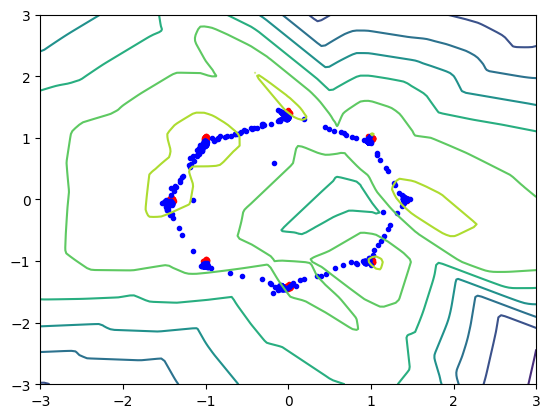

In [44]:
N_points_G=1000
true_data,centers=Data_gen(batch_size)

generate_image(true_data,MLP,N_points_G,centers)


In [34]:
def generate_image(true_dist,MLP,N_points_G,real_dict):
    
    kld_list = [] # store KL Divergence for each mode
    wass_dis = [] #store wasserstain Distance
    N_p = 128
    M = 3
    
    #These lines create an array points of the shape [N_p, N_p, 2].
    #It is used to store points that are uniformly distributed in a two-dimensional space.
    #These points are subsequently used to compute the output values of the discriminator at different 
    #locations to draw the decision boundary
    
    points = np.zeros([N_p, N_p, 2], dtype='float32')
    points[:, :, 0] = np.linspace(-M, M, N_p)[:, None]
    points[:, :, 1] = np.linspace(-M, M, N_p)[None, :]
    points = points.reshape((-1, 2))
    
    with torch.no_grad():
        
        points_v=torch.tensor(points,device=device)

        disc_map = MLP.Forward_Discriminator(points_v).cpu().numpy()

        noise_v = torch.randn([N_points_G, 2],device=device)

        samples = MLP.Forward_Generator(noise_v).cpu().numpy()
        

    
    plt.clf()
    
    
    true_dist=true_dist.detach().to('cpu').numpy()
    
    
    x = y = np.linspace(-M, M, N_p)
    plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())

    plt.scatter(true_dist[:, 0], true_dist[:, 1], c='red', marker='.')  # true data
    plt.scatter(samples[:, 0], samples[:, 1], c='blue', marker='.')  # fake sample
    
    
    
    counter = 0  
    
    #loop dictionary
    for key,real_data_point in real_dict.items():
        center_samples = filter_samples(samples, key, real_data_point)
        
        kde_generated = gaussian_kde(center_samples.T)
        
        #calculate the density for real data
        kde_real = gaussian_kde(real_data_point.to('cpu').T, bw_method='silverman')
        keys = np.array(literal_eval(str(key)))
        
        x_min, x_max = keys[0] - 1, keys[0] + 1
        y_min, y_max = keys[1] - 1, keys[1] + 1
        x_grid, y_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
        
        density_generated = kde_generated(positions).T.reshape(x_grid.shape)
        density_real = kde_real(positions).T.reshape(x_grid.shape)
        
        #KL Divergence
        kl_divergence = kl_div(density_real.ravel(), density_generated.ravel()).sum()
        counter = counter + 1
        
        kld_list.append(kl_divergence)
        
        #wasserstain distance
        pdf_real_flat = density_real.ravel() / np.sum(density_real.ravel())
        pdf_generated_flat = density_generated.ravel() / np.sum(density_generated.ravel())
        cost_matrix = cdist(positions.T, positions.T, 'euclidean')
        
        

        wasserstein_distance = ot.emd2(pdf_real_flat, pdf_generated_flat, cost_matrix)
        wass_dis.append(wasserstein_distance)
        
        print(f"KL Divergence{counter} : ",kl_divergence)
        print(f"Wassertain Distance{counter} : ",wasserstein_distance)

     
    dis_var = np.var(wass_dis)
    std = np.std(wass_dis)
    print(f"Variance : {dis_var}")
    print(f"Standard Deviation : {std}")
    


In [6]:
def filter_samples(samples, key, real_data_points, threshold=1.0):
    
    filtered_samples = []
    
    keys = np.array(literal_eval(str(key)))
    
    #filter the samples distance less than 1.0 around mode to calculate distribution distance and kl divergence
    
    real_data_points = real_data_points.tolist()
    for sample in samples:
        if np.linalg.norm(sample - keys) < threshold and (sample.tolist()) not in real_data_points:
            filtered_samples.append(sample)
    filtered_samples = np.array(filtered_samples)
    return filtered_samples
